In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [7]:
import zipfile
with zipfile.ZipFile('./Image_classification_data.zip','r') as zip_ref:
    zip_ref.extractall('./')

In [2]:
full_data = pd.read_csv('data_labels_mainData.csv')
#train_data.head()

In [ ]:
import glob
img_list = []
for filepath in glob.glob('./patch_images/*.png', recursive=False):
    img_list.append(filepath)
    


df = pd.DataFrame(data=img_list, columns=['ImageName'])
d=pd.concat(df,full_data,sort=False)
#data = full_data.merge(df,on='InstanceID')

In [ ]:
INPUT_DIR = "../input/"
training_dir = INPUT_DIR + "train/"
data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir. '*.png'))})
data_frame['']

In [41]:
df.head()

,ImageName
0,./patch_images/7622.png
1,./patch_images/5216.png
2,./patch_images/21695.png
3,./patch_images/8910.png
4,./patch_images/16270.png


In [42]:
data.head()

,ImageName,InstanceID,patientID,cellTypeName,cellType,isCancerous


In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [12]:
train_data.describe(include=['object','int64'])

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
count,9896.000000,9896.000000,9896,9896,9896.000000,9896.000000
unique,NaN,NaN,9896,4,NaN,NaN
top,NaN,NaN,16736.png,epithelial,NaN,NaN
freq,NaN,NaN,1,4079,NaN,NaN
mean,10193.880154,29.762025,NaN,NaN,1.501516,0.412187
std,6652.912660,17.486553,NaN,NaN,0.954867,0.492253
min,1.000000,1.000000,NaN,NaN,0.000000,0.000000
25%,4135.750000,14.000000,NaN,NaN,1.000000,0.000000
50%,9279.500000,26.000000,NaN,NaN,2.000000,0.000000
75%,16821.250000,47.000000,NaN,NaN,2.000000,1.000000


In [3]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(full_data, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=0)

print(f'Train data :{train_data.shape[0]}, Val Data: {val_data.shape[0]}, Test Data: {test_data.shape[0]}')

Train data :5937, Val Data: 1979, Test Data: 1980


In [4]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [5]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.1.3'

In [7]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


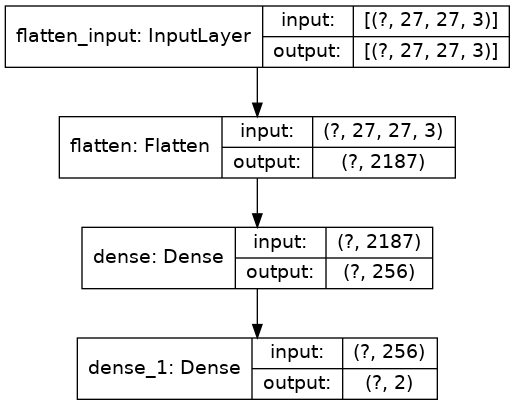

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [16]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255astypeta_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 5937 invalid image filename(s) in x_col="ImageName". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1979 invalid image filename(s) in x_col="ImageName". These filename(s) will be ignored.
  .format(n_invalid, x_col)
